# Dependencies



In [ ]:
%%capture

%pip install -qU langchain langchain-openai langchain-core langchain-community langsmith langchainhub

In [ ]:
from uuid import uuid4
import os
from google.colab import userdata

unique_id = uuid4().hex[0:8]

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Simple function calling - {unique_id}"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

#1.Starting with the basics: simple function calling

## Function calling prompt

In [ ]:
function_calling_prompt = """
You are a helpful assistant.
To assist, you can use the tools described below.

When you chose to utilise a tool, make sure to format your answer following the output required by the tool.

Your available tools are:

calculate:
Runs a calculation and returns the number.
For example, 4 * 765
Output format:
calculate:4 * 765

get_the_weather:
Get the weather in the city or region specified.
For example, "What is the weather in New-York City?"
Output format:
get_the_weather: New-York City

""".strip()

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")

messages = [
    SystemMessage(content=function_calling_prompt),
    HumanMessage(content="What is the weather in Paris?")
]

result = model.invoke(messages)

result.pretty_print()

================================== Ai Message ==================================

get_the_weather: Paris


From this output, it is very easy to get the function name and argument to pass.

In [ ]:
def get_function_name(output: str):
  return output.split(":")[0].strip()

def get_function_argument(output: str):
  return output.split(":")[1].strip()

function_to_execute = get_function_name(result.content)

print(function_to_execute)
print(get_function_argument(result.content))

get_the_weather
Paris


Here we verify that if no function call is required, the llm does not call any tool.

In [ ]:
messages = [
    SystemMessage(content=function_calling_prompt),
    HumanMessage(content="What is a rose?"),
]

result = model.invoke(messages)

result.pretty_print()

================================== Ai Message ==================================

A rose is a type of flowering shrub belonging to the genus Rosa in the family Rosaceae. Roses are known for their beautiful and often fragrant flowers, which come in various colors including red, pink, white, and yellow. They are one of the most popular and widely cultivated groups of flowering plants, prized for their aesthetic appeal and symbolic meanings, often associated with love and romance. Roses can be used in gardens, as ornamental plants, in perfumes, and for creating rose water or rose oil.


## Proto-agent



What we did before is direct function calling. The question asked directly matched the description of one of the tools available.

Now we take one step closer to agentic behavior, by asking a question that would indirectly benefit from the support of one of the two tools.

In [ ]:
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")

messages = [
    SystemMessage(content=function_calling_prompt),
    HumanMessage(content="I am going to New-York City tomorrow, do I need to bring an umbrella with me?"),
]

result = model.invoke(messages)

result.pretty_print()

================================== Ai Message ==================================

Let me check the weather in New-York City for you.

get_the_weather: New-York City


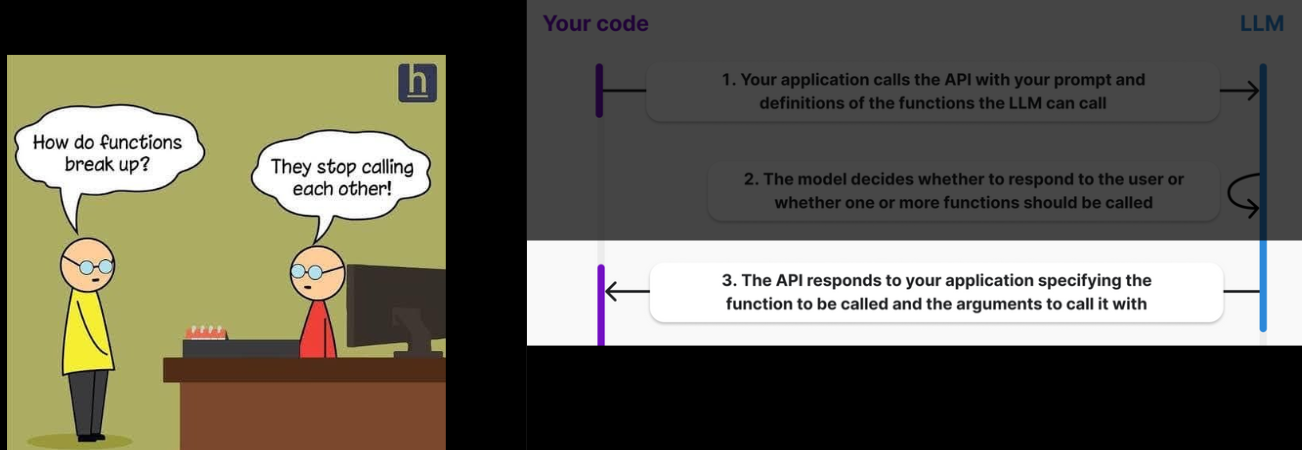

We can now pass back the result of the function call to the model, by adding a `FunctionMessage` to the stack of existing messages.

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, FunctionMessage
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")

messages = [
    SystemMessage(content=function_calling_prompt),
    HumanMessage(content="I am going to New-York City tomorrow, do I need to bring an umbrella with me?"),
    # New message which contains both the result of the function call and a reference
    # to the function that was called.
    FunctionMessage(
        content="Tomorrow the weather in New-York City is sunny for the entire day",
        name="get_the_weather"),
]

result = model.invoke(messages)

result.pretty_print()

================================== Ai Message ==================================

The weather in New-York City tomorrow is expected to be sunny for the entire day, so you likely won't need to bring an umbrella with you. Enjoy your trip!


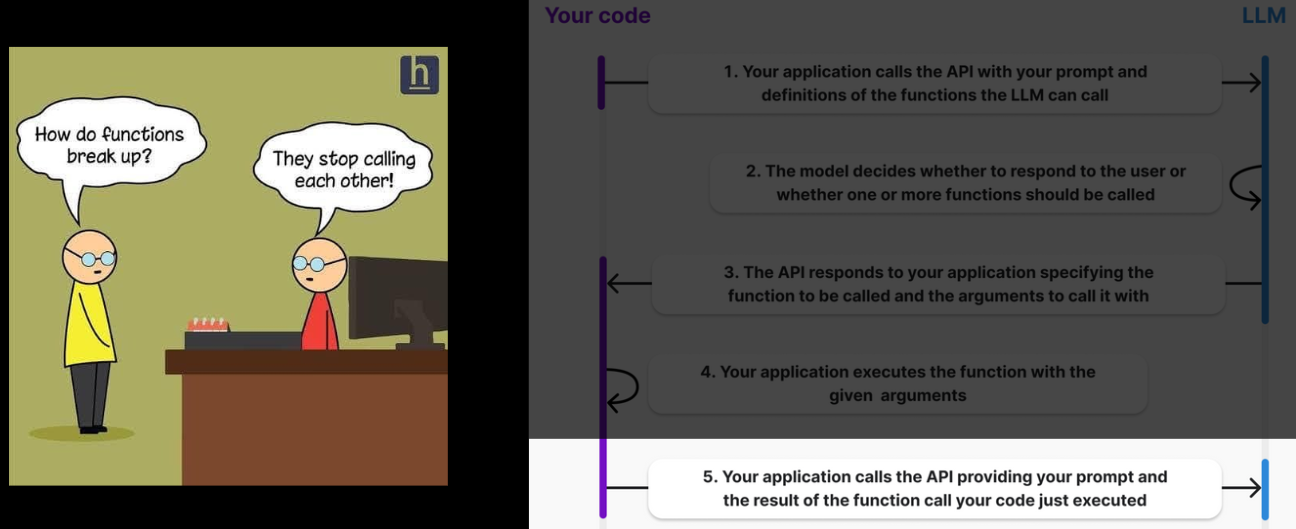

As we can see, the model answered using the additional information provided by the function call.

#2.Building a ReAct agent from scratch

Now we will go one step further and build a full ReAct agent from scratch. Previously, the result of the function call was generated manually, it was then added to the stack of messages manually, and was sent back to the model manually. All these steps should be done automatically in the agent we are going to build.

This ReAct agent will work throught the steps of:
1. Thought,
2. Action (do something, use a tool),
3. Observation of the results of this action (or of the use of this tool),
4. Start again if needed.



Let's build this from scratch!

In [ ]:
from uuid import uuid4
import os
from google.colab import userdata

unique_id = uuid4().hex[0:8]

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Build-an-agent-from-scratch - {unique_id}"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

## Create the ReAct prompt

We create a ReAct prompt with the three steps:


1.   Thought
2.   Action
3.   Pause

and the two following tools:



1.   caculate
2.   get_average_animal_weight

The prompt must contain a description of what each tool does so that the LLM can identify which tool to use and generate instructions to make using this tool possible.

In [ ]:
react_prompt = """
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer.
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs the calculation and returns the result.

get_average_animal_weight:
e.g. average_animal_weight: lion
Returns the average weight of the animal specified.

Example session:

Question: How much does an elephant weigh?
Thought: I should look the elephant weight using get_average_animal_weight
Action: get_average_animal_weight: elephant
PAUSE

You will be called again with this:

Observation: An elephant weights on average 4000 kgs

You then output:

Answer: An elephant weights on average 4000 kgs
""".strip()

## Create the agent

In [ ]:
class Agent:
  def __init__(self, system_prompt="", model=ChatOpenAI(model='gpt-4o')):
    self.system_prompt = system_prompt
    self.messages = []
    self.model = model

    if self.system_prompt:
      self.messages.append(
          SystemMessage(self.system_prompt)
      )

  def __call__(self, message):
    self.messages.append(HumanMessage(message))
    response = self.run_model()
    self.messages.append(response)
    return response

  def run_model(self):
    return self.model.invoke(self.messages)

  def view_all_messages(self):
    for message in self.messages:
      message.pretty_print()
      print("\n\n")

## Define the tools

Now we define the tools that the agent can use:

In [ ]:
def calculate(what):
    # It's a very bad idea to use eval like this without control on 'what'. But
    # I like bad ideas. However, do not use in production.
    return eval(what)

def get_average_animal_weight(name):
    if name in "lion":
        return("Lions average 200 kgs")
    elif name in "elephant":
        return("an elephant average weight is 4000 kgs")
    elif name in "hyena":
        return("a hyena average weight is 40 kgs")
    elif name in "leopard":
        return("An average leopard weights 50 kgs")

## Run with a simple prompt

In [ ]:
agent = Agent(react_prompt)

result = agent("How much does an elephant weigh?")

result.pretty_print()

================================== Ai Message ==================================

Thought: I should look up the elephant's weight using get_average_animal_weight.
Action: get_average_animal_weight: elephant
PAUSE


In [ ]:
result = get_average_animal_weight("elephant")

result

'an elephant average weight is 4000 kgs'

In [ ]:
next_prompt = f"Observation: {result}"

In [ ]:
agent(next_prompt).pretty_print()

================================== Ai Message ==================================

Answer: An elephant weighs on average 4000 kgs.


In [ ]:
agent.view_all_messages()

================================ System Message ================================

You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer.
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs the calculation and returns the result.

get_average_animal_weight:
e.g. average_animal_weight: lion
Returns the average weight of the animal specified.

Example session:

Question: How much does an elephant weigh?
Thought: I should look the elephant weight using get_average_animal_weight
Action: get_average_animal_weight: elephant
PAUSE

You will be called again with this:

Observation: An elephant weights on average 4000 kgs

You then output:

Answer: An elephant weights on average 4000 kgs



================================

## Run with a more complex prompt

In this example, we expect the agent to fetch the average weight of each of the 3 animals (so 3 calls to `get_average_animal_weight`), and to make a final call to `calculate` to get the sum.

In [ ]:
agent = Agent(react_prompt)

question = """I have 3 animals, a lion, a hyena and a leopard. \
What is their combined weight?"""

agent(question).pretty_print()

================================== Ai Message ==================================

Thought: I need to find the average weight of each animal (lion, hyena, and leopard) using get_average_animal_weight, and then calculate their combined weight.

Action: get_average_animal_weight: lion
PAUSE


In [ ]:
next_prompt = f"Observation: {get_average_animal_weight('lion')}"
print(next_prompt)

Observation: Lions average 200 kgs


In [ ]:
agent(next_prompt).pretty_print()

================================== Ai Message ==================================

Thought: Now I need to find the average weight of a hyena.

Action: get_average_animal_weight: hyena
PAUSE


In [ ]:
next_prompt = f"Observation: {get_average_animal_weight('hyena')}"
print(next_prompt)

Observation: a hyena average weight is 40 kgs


In [ ]:
agent(next_prompt).pretty_print()

================================== Ai Message ==================================

Thought: Now I need to find the average weight of a leopard.

Action: get_average_animal_weight: leopard
PAUSE


In [ ]:
next_prompt = f"Observation: {get_average_animal_weight('leopard')}"
print(next_prompt)

Observation: An average leopard weights 50 kgs


In [ ]:
agent(next_prompt).pretty_print()

================================== Ai Message ==================================

Thought: I now have the average weights of the lion (200 kgs), hyena (40 kgs), and leopard (50 kgs). I need to calculate the combined weight.

Action: calculate: 200 + 40 + 50
PAUSE


In [ ]:
next_prompt = f"Observation: {calculate('200 + 40 + 50')}"
print(next_prompt)

Observation: 290


In [ ]:
agent(next_prompt).pretty_print()

================================== Ai Message ==================================

Answer: The combined weight of a lion, a hyena, and a leopard is 290 kgs.


In [ ]:
agent.view_all_messages()

================================ System Message ================================

You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer.
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs the calculation and returns the result.

get_average_animal_weight:
e.g. average_animal_weight: lion
Returns the average weight of the animal specified.

Example session:

Question: How much does an elephant weigh?
Thought: I should look the elephant weight using get_average_animal_weight
Action: get_average_animal_weight: elephant
PAUSE

You will be called again with this:

Observation: An elephant weights on average 4000 kgs

You then output:

Answer: An elephant weights on average 4000 kgs



================================

⏸❗ It is important to notice that, with each agent call, we submit all the messages from the begining. This means that between each call we need a way to memorize the messages.


## Add the loop

All the work was done manually, so now we need to add the loop that will allow us to run the agent automatically.

### Extract the action

We start with creating the template to extract the action call from the AI message that takes this format:

> Thought: I now have the average weights for a lion (200 kgs), a hyena (40 kgs), and a leopard (50 kgs). I need to sum these weights to get the combined weight.
>
> Action: calculate: 200 + 40 + 50
>
> PAUSE



In [ ]:
import re

action_re = re.compile('^Action: (\w+): (.*)$')   # python regular expression to select action

This regex does the following:
* `^`: Anchors the match at the start of the string.
* `Action:` : Matches the literal string "Action: " at the start of the line.
* `(\w+)`: This is a capturing group. \w+ matches one or more word characters (equivalent to `[a-zA-Z0-9_]`). This group will capture whatever word comes after "Action: ".
* `: `: Matches the literal string ": " following the first word.
* `(.*)`: This is another capturing group. .* matches any character (except newline) 0 or more times. This group will capture everything that comes after the second colon and space.
* `$`: Anchors the match at the end of the string.

### Create the toolbox



In [ ]:
toolbox = {
    "calculate": calculate,
    "get_average_animal_weight": get_average_animal_weight
}

### Create the loop

In [ ]:
def run_loop(question, max_turns=5):
    i = 0
    # Initiate the agent with the system prompt for ReAct behavior
    agent = Agent(react_prompt)
    # Get ready to add the user's query as next message in the stack
    next_prompt = question
    while i < max_turns:
        i += 1
        # If it's the first round, next_prompt is the user's query
        # If it's the second round or more, next_prompt is an observation
        result = agent(next_prompt)
        result.pretty_print()

        # Apply the action_re template defined above to extract the action calls:
        actions = [
            action_re.match(a)
            for a in result.content.split('\n')
            if action_re.match(a)
        ]

        # Execute the action calls if any:
        if actions:
            action, action_input = actions[0].groups()
            if action not in toolbox:
                raise Exception(f"Unknown action: {action}: {action_input}")
            print(f"\n******* \033[1mRunning {action}('{action_input}')\033[0m ******\n")
            observation = toolbox[action](action_input)
            print("Observation:", observation, "\n")
            next_prompt = f"Observation: {observation}"
        # If no action calls are detected, exit the loop
        else:
            return

In [ ]:
question = """I have 3 animals, a lion, a hyena and a leopard. \
What is their combined weight?"""

run_loop(question)

================================== Ai Message ==================================

Thought: I need to find the average weight of each of the three animals: a lion, a hyena, and a leopard. Then I will add these weights together to get the combined weight.

Action: get_average_animal_weight: lion
PAUSE

******* Running get_average_animal_weight('lion') ******

Observation: Lions average 200 kgs 

================================== Ai Message ==================================

Thought: I have the average weight of a lion. Next, I need to find the average weight of a hyena.

Action: get_average_animal_weight: hyena
PAUSE

******* Running get_average_animal_weight('hyena') ******

Observation: a hyena average weight is 40 kgs 

================================== Ai Message ==================================

Thought: I have the average weights of a lion and a hyena. Now, I need to find the average weight of a leopard.

Action: get_average_animal_weight: leopard
PAUSE

******* Running get_av

#3.Building the agent the easy lazy way

In [ ]:
from uuid import uuid4
import os
from google.colab import userdata

unique_id = uuid4().hex[0:8]

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Build-an-agent-the-easy-lazy-way - {unique_id}"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

## Create the tools and the toolbox

Now we build the agent using LangChain abstraction, which will make our work much easier, and faster.

The toolbox here contains two functions that allow to:
1. Get the average weight of selected animals
2. Run a math computation

In [ ]:
from langchain.tools import tool

@tool
def calculate(what):
    """A tool to calculate or run math computation."""
    return what

@tool
def get_average_animal_weight(name):
    """A tool to get the weight of selected animals."""
    if name in "lion":
        return("Lions average 200 kgs")
    elif name in "elephant":
        return("an elephant average weight is 4000 kgs")
    elif name in "hyena":
        return("a hyena average weight is 40 kgs")
    elif name in "leopard":
        return("An average leopard weights 50 kgs")

toolbox = [calculate, get_average_animal_weight]

## Create and run the LangChain assistant

In [ ]:
from langchain import hub
from langchain.agents import create_tool_calling_agent
from langchain.agents import AgentExecutor
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")

# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/openai-functions-agent")
prompt.pretty_print()

# Create the agent and bind the tools
agent = create_tool_calling_agent(model, toolbox, prompt)
agent_executor = AgentExecutor(agent=agent, tools=toolbox, verbose=True)

================================ System Message ================================

You are a helpful assistant

============================= Messages Placeholder =============================

{chat_history}

================================ Human Message =================================

{input}

============================= Messages Placeholder =============================

{agent_scratchpad}


In [ ]:
# Run the agent with the question
question = """I have 3 animals, a lion, a hyena and a leopard. \
What is their combined weight?"""

agent_executor.invoke({"input": question})



> Entering new AgentExecutor chain...

Invoking: `get_average_animal_weight` with `{'name': 'lion'}`


Lions average 200 kgs
Invoking: `get_average_animal_weight` with `{'name': 'hyena'}`


a hyena average weight is 40 kgs
Invoking: `get_average_animal_weight` with `{'name': 'leopard'}`


An average leopard weights 50 kgs
Invoking: `calculate` with `{'what': '200 + 40 + 50'}`


200 + 40 + 50The combined weight of the lion, hyena, and leopard is 290 kgs.

> Finished chain.


{'input': 'I have 3 animals, a lion, a hyena and a leopard. What is their combined weight?',
 'output': 'The combined weight of the lion, hyena, and leopard is 290 kgs.'}

That was easy and painless.

#4.BONUS: Building the agent with LangGraph

We are now going to build the same agent (form scratch, again) with LangGraph.

## Dependencies

In [ ]:
%pip install -qU langchain langchain-openai langchain-core langchain-community langgraph langsmith

In [ ]:
from uuid import uuid4
import os
from google.colab import userdata

unique_id = uuid4().hex[0:8]

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"Build-an-agent-with-langgraph - {unique_id}"
os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

In [ ]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI

## Create the agent

### Declare the graph `state` variable

The `state` of a graph:
* is accessible to all parts of the graph
* is local to the graph in question
* can be stored in a persistence layer

In this simple exemple, the `state` only consists in a list of messages (the history of the graph). Each new list of messages returned by any node of the graph will be appended to the existing list, due to `operator.add`.

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

### Declare the agent's graph

Next, the graph on which the agent is based is declared.

The graph is a **collection of nodes** (llm nodes, action nodes, end nodes) linked together with **edges** (automatic transition between nodes) and **condition edges** (transition between edges based on a condition).

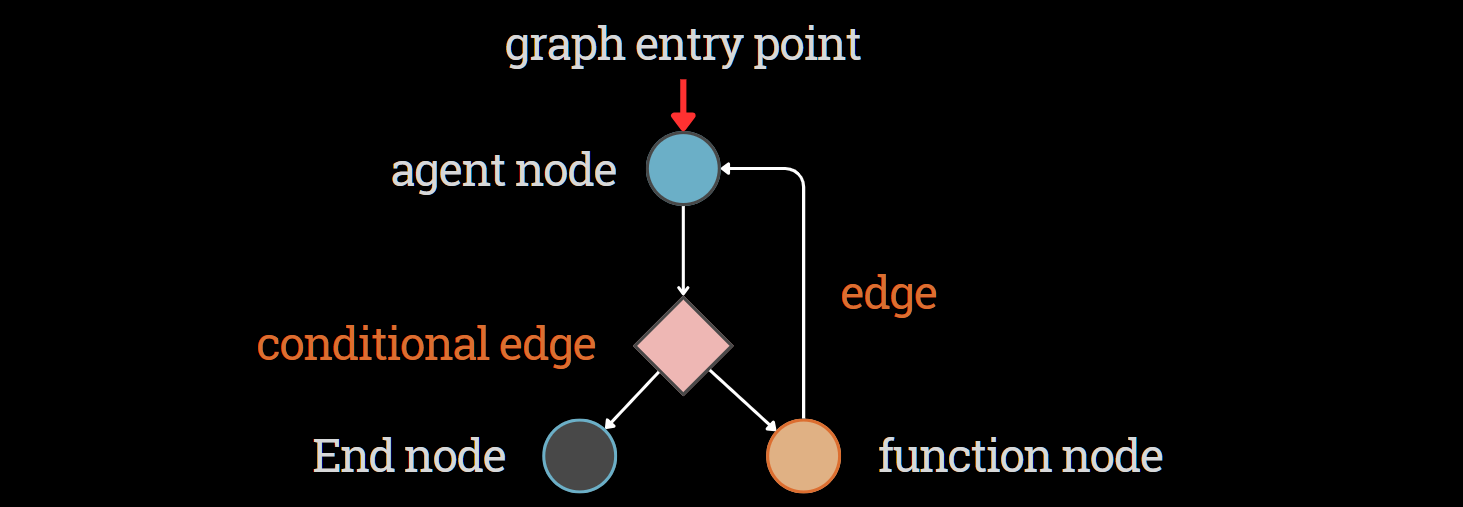

In [ ]:
class Agent:
    def __init__(self, model, tools, system=""):
        """Upon initialisation of the Agent, the graph is created."""
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        """Check if there is a tool call to process.
        Return an integer higher than 0 if there is one."""
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [ ]:
from langchain.tools import tool

@tool
def calculate(what):
    """A tool to calculate or run math computation."""
    return what

@tool
def get_average_animal_weight(name):
    """A tool to get the weight of selected animals."""
    if name in "lion":
        return("Lions average 200 kgs")
    elif name in "elephant":
        return("an elephant average weight is 4000 kgs")
    elif name in "hyena":
        return("a hyena average weight is 40 kgs")
    elif name in "leopard":
        return("An average leopard weights 50 kgs")

In [ ]:
toolbox = [calculate, get_average_animal_weight]

In [ ]:
prompt = """You are a smart research assistant. Use the tools at your disposal \
to look up information or execute a computation. \
You are allowed to make multiple calls (either together or in sequence). \
"""

model = ChatOpenAI(model="gpt-4o")
agent = Agent(model, toolbox, system=prompt)

In [ ]:
from IPython.display import Image

# This does not work well in Google Colab notebook, but works well when run locally.
# Image(agent.graph.get_graph().draw_png())

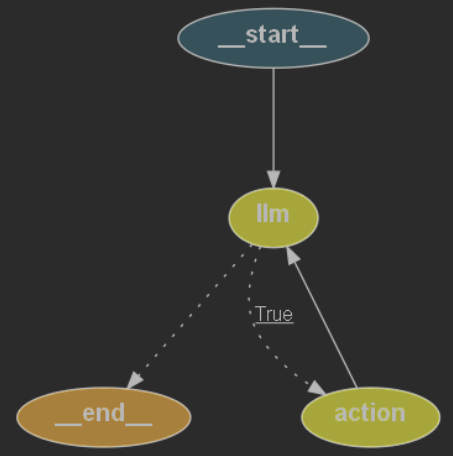

In [ ]:
messages = [
    HumanMessage(content="I have 3 animals, a lion, a hyena and a leopard. \
What is their combined weight?")
    ]
result = agent.graph.invoke({"messages": messages})

Calling: {'name': 'get_average_animal_weight', 'args': {'name': 'lion'}, 'id': 'call_1QxXv0FDt5SKSa0OayXejjGh', 'type': 'tool_call'}
Calling: {'name': 'get_average_animal_weight', 'args': {'name': 'hyena'}, 'id': 'call_d61DkuXVsJfZGkYvoDwCnhva', 'type': 'tool_call'}
Calling: {'name': 'get_average_animal_weight', 'args': {'name': 'leopard'}, 'id': 'call_4j5Agcu25zeB5IuYxGc1yVlO', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'calculate', 'args': {'what': '200 + 40 + 50'}, 'id': 'call_UBqtB5N0cXFJEeRRglhCx02y', 'type': 'tool_call'}
Back to the model!


In [ ]:
for message in result['messages']:
  message.pretty_print()

================================ Human Message =================================

I have 3 animals, a lion, a hyena and a leopard. What is their combined weight?
================================== Ai Message ==================================
Tool Calls:
  get_average_animal_weight (call_1QxXv0FDt5SKSa0OayXejjGh)
 Call ID: call_1QxXv0FDt5SKSa0OayXejjGh
  Args:
    name: lion
  get_average_animal_weight (call_d61DkuXVsJfZGkYvoDwCnhva)
 Call ID: call_d61DkuXVsJfZGkYvoDwCnhva
  Args:
    name: hyena
  get_average_animal_weight (call_4j5Agcu25zeB5IuYxGc1yVlO)
 Call ID: call_4j5Agcu25zeB5IuYxGc1yVlO
  Args:
    name: leopard
================================= Tool Message =================================
Name: get_average_animal_weight

Lions average 200 kgs
================================= Tool Message =================================
Name: get_average_animal_weight

a hyena average weight is 40 kgs
================================= Tool Message =================================
Name: ge

#5.Comparing the cost and time of each method

Since everything has been tracked in LangSmith, we can compare the cost and latency for each approach.

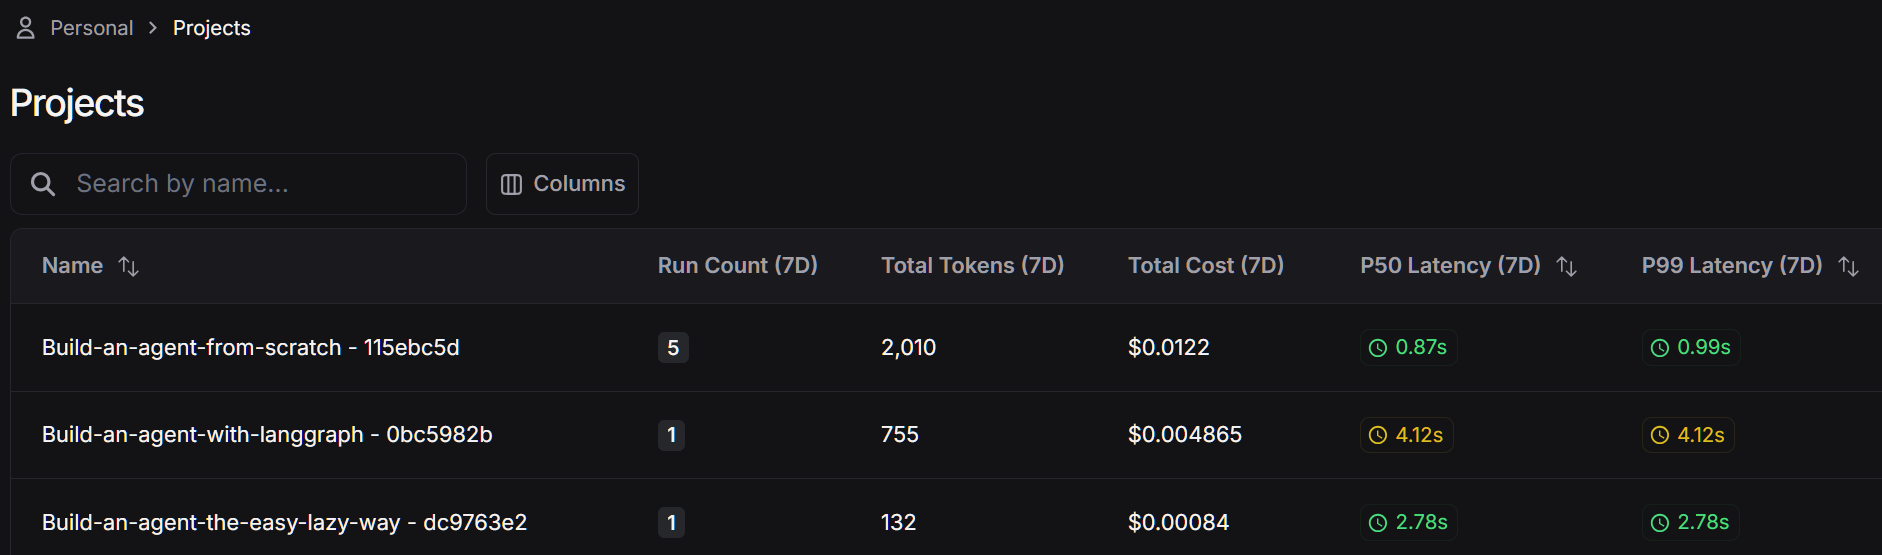

❓Why do we see such a price difference? You have all the traces in this notebook to answer this question. Enjoy!

#6.BONUS: Tree of Thoughts (**ToT**)

Let's explore a new reasoning pattern now, called tree of thoughts, and apply it to solving a game of Sudoku.

The ToT approach is inspired by how humans often think through problems by exploring different possibilities before deciding on a final solution.

See the original paper here: https://arxiv.org/abs/2305.10601

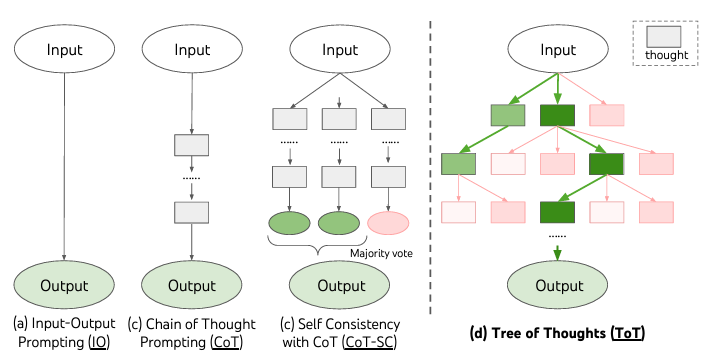

In [ ]:
%%capture

%pip install -qU langchain-experimental

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 kB 1.8 MB/s eta 0:00:00


In [ ]:
from langchain_openai import ChatOpenAI
import langchain

langchain.verbose = False

llm = ChatOpenAI(
    model="gpt4o",
    temperature=0,
)

In [ ]:
sudoku_puzzle = "3,*,*,2|1,*,3,*|*,1,*,3|4,*,*,1"
sudoku_solution = "3,4,1,2|1,2,3,4|2,1,4,3|4,3,2,1"
problem_description = f"""
{sudoku_puzzle}

- This is a 4x4 Sudoku puzzle.
- The * represents a cell to be filled.
- The | character separates rows.
- At each step, replace one or more * with digits 1-4.
- There must be no duplicate digits in any row, column or 2x2 subgrid.
- Keep the known digits from previous valid thoughts in place.
- Each thought can be a partial or the final solution.
""".strip()
print(problem_description)

3,*,*,2|1,*,3,*|*,1,*,3|4,*,*,1

- This is a 4x4 Sudoku puzzle.
- The * represents a cell to be filled.
- The | character separates rows.
- At each step, replace one or more * with digits 1-4.
- There must be no duplicate digits in any row, column or 2x2 subgrid.
- Keep the known digits from previous valid thoughts in place.
- Each thought can be a partial or the final solution.


In [ ]:
import re
from typing import Tuple

from langchain_experimental.tot.checker import ToTChecker
from langchain_experimental.tot.thought import ThoughtValidity


class MyChecker(ToTChecker):
    def evaluate(
        self, problem_description: str, thoughts: Tuple[str, ...] = ()
    ) -> ThoughtValidity:
        last_thought = thoughts[-1]
        clean_solution = last_thought.replace(" ", "").replace('"', "")
        regex_solution = clean_solution.replace("*", ".").replace("|", "\\|")
        if sudoku_solution in clean_solution:
            return ThoughtValidity.VALID_FINAL
        elif re.search(regex_solution, sudoku_solution):
            return ThoughtValidity.VALID_INTERMEDIATE
        else:
            return ThoughtValidity.INVALID

In [ ]:
from langchain_experimental.tot.base import ToTChain

tot_chain = ToTChain(
    llm=llm, checker=MyChecker(), k=30, c=5, verbose=True, verbose_llm=False
)
tot_chain.run(problem_description=problem_description)



> Entering new ToTChain chain...
Starting the ToT solve procedure.


/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:339: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Thought: 3,*,*,2|1,2,3,*|*,1,*,3|4,*,*,1


/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:339: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


    Thought: 3,*,*,2|1,2,3,*|*,1,*,3|4,*,2,1


/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:339: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


        Thought: 3,*,*,2|1,2,3,*|*,1,4,3|4,*,2,1


/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:339: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


            Thought: 3,*,*,2|1,2,3,*|*,1,4,3|4,*,2,1


/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:339: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


                Thought: 3,*,*,2|1,2,3,*|2,1,4,3|4,*,2,1


/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:339: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


                    Thought: 3,*,*,2|1,2,3,*|2,1,4,3|4,3,2,1


/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:339: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


                        Thought: 3,4,*,2|1,2,3,*|2,1,4,3|4,3,2,1


/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:339: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


                            Thought: 3,4,*,2|1,2,3,*|2,1,4,3|4,3,2,1


/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:339: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


                                Thought: 3,4,1,2|1,2,3,*|2,1,4,3|4,3,2,1


/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:339: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


                                    Thought: 3,4,1,2|1,2,3,*|2,1,4,3|4,3,2,1


/usr/local/lib/python3.10/dist-packages/langchain/chains/llm.py:339: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


                                        Thought: 3,4,1,2|1,2,3,4|2,1,4,3|4,3,2,1

> Finished chain.


'3,4,1,2|1,2,3,4|2,1,4,3|4,3,2,1'